# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [ ]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

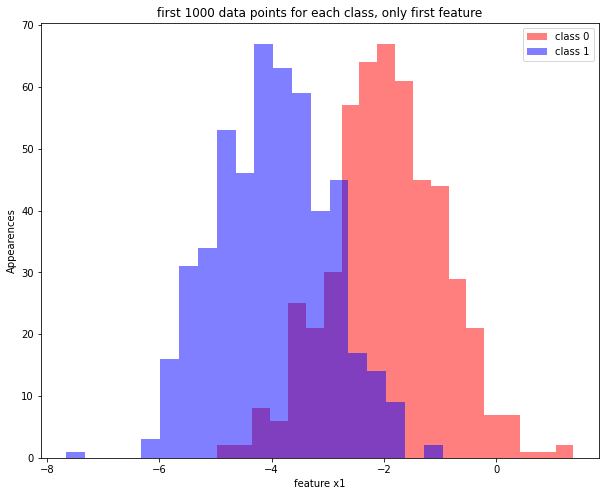

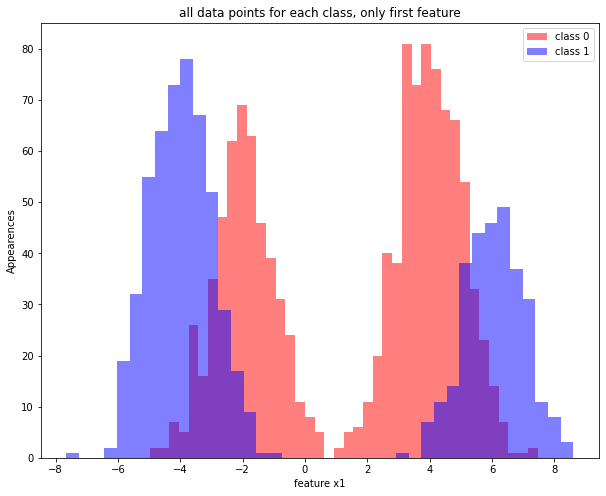

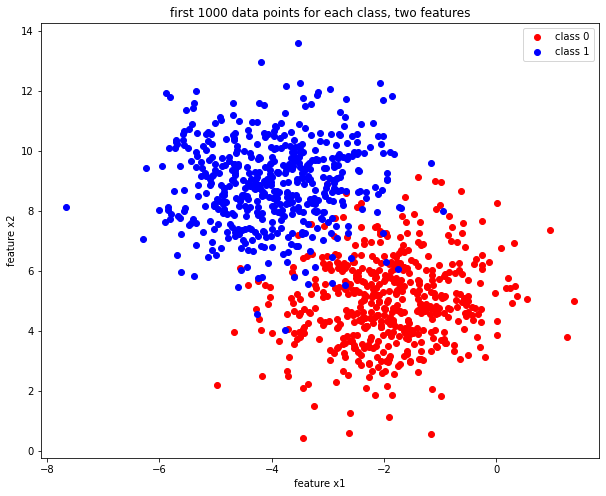

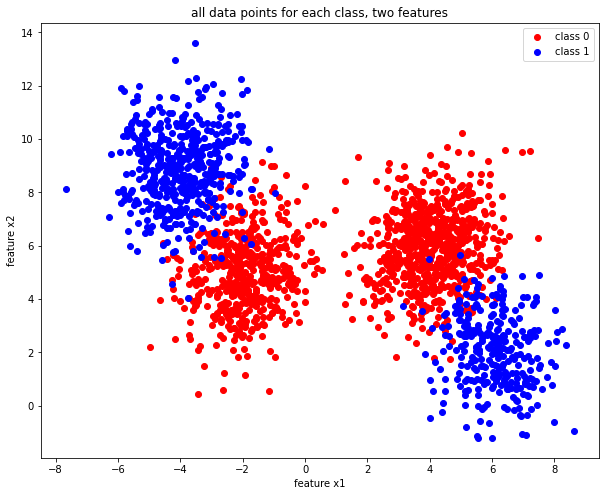

In [ ]:
#1
first_1000_first_feature = training_set[0:1000][['x1', 'y']]
class_0 = first_1000_first_feature[first_1000_first_feature['y'] == 0]
class_1 = first_1000_first_feature[first_1000_first_feature['y'] == 1]
plt.hist(class_0['x1'], bins = 20, alpha = 0.5, color='r', label='class 0')
plt.hist(class_1['x1'], bins = 20, alpha = 0.5, color='b', label='class 1')
plt.legend()
plt.title("first 1000 data points for each class, only first feature")
plt.xlabel("feature x1")
plt.ylabel("Appearences")
plt.show()

#2
all_first_feature = training_set[['x1', 'y']]
class_0 = all_first_feature[all_first_feature['y'] == 0]
class_1 = all_first_feature[all_first_feature['y'] == 1]
plt.hist(class_0['x1'], bins = 40, alpha = 0.5, color='r', label='class 0')
plt.hist(class_1['x1'], bins = 40, alpha = 0.5, color='b', label='class 1')
plt.legend()
plt.title("all data points for each class, only first feature")
plt.xlabel("feature x1")
plt.ylabel("Appearences")
plt.show()

#3
first_1000 = training_set[0:1000]
class_0 = first_1000[first_1000['y'] == 0]
class_1 = first_1000[first_1000['y'] == 1]
plt.scatter(class_0['x1'], class_0['x2'], color='r', label='class 0')
plt.scatter(class_1['x1'], class_1['x2'], color='b', label='class 1')
plt.legend()
plt.title("first 1000 data points for each class, two features")
plt.xlabel("feature x1")
plt.ylabel("feature x2")
plt.show()

#4
class_0 = training_set[training_set['y'] == 0]
class_1 = training_set[training_set['y'] == 1]
plt.scatter(class_0['x1'], class_0['x2'], color='r', label='class 0')
plt.scatter(class_1['x1'], class_1['x2'], color='b', label='class 1')
plt.legend()
plt.title("all data points for each class, two features")
plt.xlabel("feature x1")
plt.ylabel("feature x2")
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [ ]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        #thetas
        self.thetas = None
        #cost per iteration
        self.J_history = []

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        #cost function, correct the bug
        cost_logist = lambda y,h_x : (1/y.shape[0])*(-y@np.log(h_x)-(1-y)@np.log(1-h_x))
        #bias trick
        X = np.column_stack((np.ones(len(X)), X)) 
        #initiate random thetas
        np.random.seed(self.random_state)
        self.thetas = np.random.random(X.shape[1]) 
        #start gradient descent loop and save costs history
        for i in range(self.n_iter):
            h = self.calcHypothesis(X@self.thetas)
            self.thetas -= (self.eta) * ((np.transpose(h - y))@X) 
            self.J_history.append(cost_logist(y, h))
            # self.J_history.append(self.calcCost(y, h))
            if i > 0:
                if np.abs(self.J_history[i-1] - self.J_history[i]) < self.eps:
                    break

    def predict(self, X):
        #bias trick
        X = np.column_stack((np.ones(len(X)), X)) 
        #hypothesis and rounding
        h = self.calcHypothesis(X@self.thetas) 
        h[h>=0.5] = 1
        h[h<0.5] = 0
        return h

    def evaluate(self, X_test, y_test):      
        # correct = (self.predict(X_test) == y_test).sum()
        # return (correct/ y_test.size)
        return np.mean(y_test==self.predict(X_test))

    def calcHypothesis(self, a):
        return 1/(1+ np.exp(-a))    

    def calcCost(self, X, y):
        cost = -y*np.log(self.calcHypothesis(X))- (1-y)*np.log(1-self.calcHypothesis(X))
        cost = np.sum(cost)/len(X)
        return cost

logistic_regrssion = LogisticRegressionGD()
logistic_regrssion.fit(X_training, y_training)
print(logistic_regrssion.evaluate(X_test, y_test))

0.804


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
k_fold = 5

best_eta = None
best_eps = None
best_average_accuracy = 0

training_set_shuffle = pd.read_csv('training_set.csv').sample(frac=1)
splitted_train = np.array_split(training_set_shuffle, k_fold)
for eta in etas:
    for eps in epss:
        accuracies = []
        for i in range(k_fold):
            logistic_classifier = LogisticRegressionGD(eta=eta, eps=eps);
            
            #validation set
            validation_set = pd.DataFrame(splitted_train[i], columns=training_set.columns)
            X_val, y_val = validation_set[['x1', 'x2']].values, validation_set['y'].values

            #without validation set
            without_validation_set = splitted_train.copy()
            without_validation_set.pop(i)
            without_validation_set = pd.concat(without_validation_set)
            X_train, y_train = without_validation_set[['x1', 'x2']].values, without_validation_set['y'].values

            #train model and then check accuracy
            logistic_classifier.fit(X_train, y_train)
            accuracies.append(logistic_classifier.evaluate(X_val, y_val))
        avg_accuracy = np.mean(accuracies)

        if avg_accuracy > best_average_accuracy:
            best_average_accuracy = avg_accuracy
            best_eta = eta
            best_eps = eps

print(best_average_accuracy,",",best_eta,",",best_eps)


0.8009999999999999 , 5e-05 , 1e-06


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return  (1 / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * (((data-mu)/sigma)**2))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

        self.r = None
        self.J_history = []

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(42)
        self.w = np.ones(self.k)/self.k
        self.mu = np.random.random(self.k)
        self.sigma = np.random.random(self.k)

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        numirator_for_each_k = []
        denominator = 0
        self.r = []
        
        #calculate all the numirator for each data point
        for j in range(self.k):
          wj = self.w[j]
          muj =self.mu[j]
          sigmaj = self.sigma[j]
          #[[][][][][]]
          numirator_for_each_k.append(wj*norm_pdf(data, muj, sigmaj))
        
        #calculate denominator for each data point
        denominator = np.sum(numirator_for_each_k, axis=0)

        #responsibility for each gausian
        for i in range(self.k):
          #[[][][][][]]
          self.r.append(numirator_for_each_k[i]/denominator)
        
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        data_size = len(data)
        for i in range(self.k):
          #new w
          resp_i = self.r[i]
          new_w = np.sum(resp_i)/data_size
          self.w[i] = new_w

          #new mu
          new_mu = np.sum(resp_i * data) / (new_w * data_size)
          self.mu[i] = new_mu

          #new sigma
          var = np.sum(resp_i * (data - new_mu)**2) / (new_w * data_size)
          self.sigma[i] = np.sqrt(var)


    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        for i in range(self.n_iter):
            self.J_history.append(self.cost(data))
            if (len(self.J_history) >=2) and (self.J_history[-2] - self.J_history[-1] < self.eps):
                break
            self.expectation(data)
            self.maximization(data)

    def cost(self, data):
        J = 0
        Wpdfs =[]
        for i in range(self.k):
            mu = self.mu[i]
            w = self.w[i]
            sigma = self.sigma[i]
            pdf = norm_pdf(data, mu, sigma)
            Wpdf= w*pdf
            Wpdfs.append(w*pdf)
        Wpdfs = np.sum(Wpdfs, axis=0)
        J = np.sum(-np.log(Wpdfs))
        return J

    def get_dist_params(self):
        return self.w, self.mu, self.sigma
    

In [ ]:
em = EM(k=2)
em.fit(X_training[:,0])

ws, mus, sigmas = em.get_dist_params()
print(f"w: {ws}")
print(f"mu: {mus}")
print(f"sigma: {sigmas}")

w: [0.49922415 0.50077585]
mu: [-2.96303343  4.64045181]
sigma: [1.42153254 1.37563848]


## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """

        self.number_of_features = X.shape[1]
        #list of gmms 
        data_class_0 = X[y==0]
        self.gmms_class_0 = self.fit_one_class(data_class_0)
        data_class_1 = X[y==1]
        self.gmms_class_1 = self.fit_one_class(data_class_1)

        self.prior_0 = len(data_class_0)/len(X)
        self.prior_1 = len(data_class_1)/len(X)

    def predict(self, X):
        """Return the predicted class label"""
        results = []
        for sample_idx in range(X.shape[0]):
          results.append(self.predict_one_sample(X[sample_idx, :]))
        return np.array(results)
    
    def fit_one_class(self, data):
        list_of_gmms=[]
        for feature_idx in range(self.number_of_features):
            data_current_feature = data[:,feature_idx]
            list_of_gmms.append(EM(k = self.k))
            list_of_gmms[feature_idx].fit(data_current_feature)
        return np.array(list_of_gmms)

    def calculate_gmm_pdf(self, scalar, gmm):
        current_likelihood = 0
        ws, mus, sigmas = gmm.get_dist_params()
        for gausian_idx in range(self.k):
            em_w = ws[gausian_idx]
            em_mu = mus[gausian_idx]
            em_sigma = sigmas[gausian_idx]
            current_likelihood+=(em_w*norm_pdf(scalar, em_mu, em_sigma))
        return current_likelihood

    def predict_one_sample(self, sample):
      likelyhood_class_0 = 1
      likelyhood_class_1 = 1
      for feature_idx in range(self.number_of_features):
        current_feature = sample[feature_idx]
        current_gmm_class_0 = self.gmms_class_0[feature_idx]
        current_gmm_class_1 = self.gmms_class_1[feature_idx]
        likelyhood_class_0*= self.calculate_gmm_pdf(current_feature, current_gmm_class_0)
        likelyhood_class_1*= self.calculate_gmm_pdf(current_feature, current_gmm_class_1)
      posterior_0 = self.prior_0*likelyhood_class_0
      posterior_1 = self.prior_1*likelyhood_class_1
      if (posterior_0>posterior_1):
        return 0
      return 1

    def accuracy(self, X, y):
        return np.mean(y==self.predict(X))



In [ ]:
NBG = NaiveBayesGaussian(k=2)
NBG.fit(X_training,y_training)
print(type(NBG.predict(X_test)))

print(NBG.accuracy(X_test, y_test))

<class 'numpy.ndarray'>
0.902


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

### First 1000 training points and first 500 test points:

For the first 1000 training points and first 500 test points:
-------------------------------------------------------------
Logistic Regression: Training Accuracy: 96.5%, Test Accuracy: 93.8%
Naive Bayes: Training Accuracy: 96.6%, Test Accuracy: 94.19999999999999%



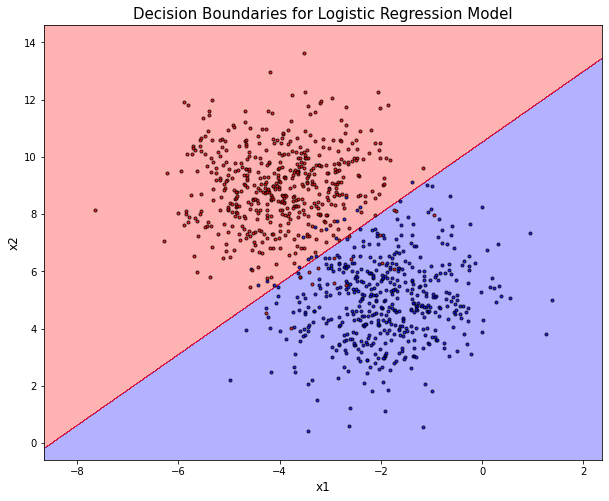

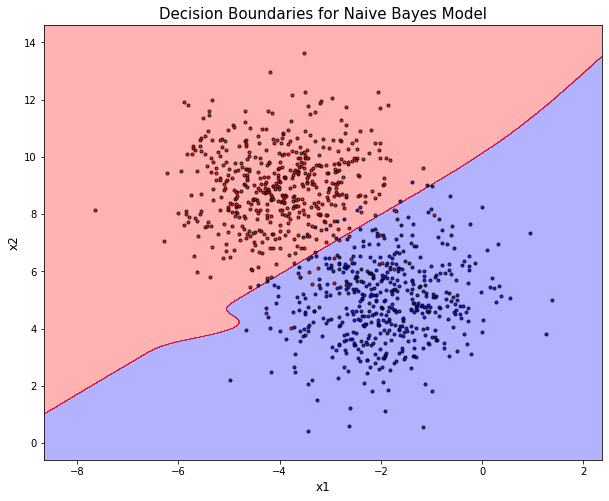

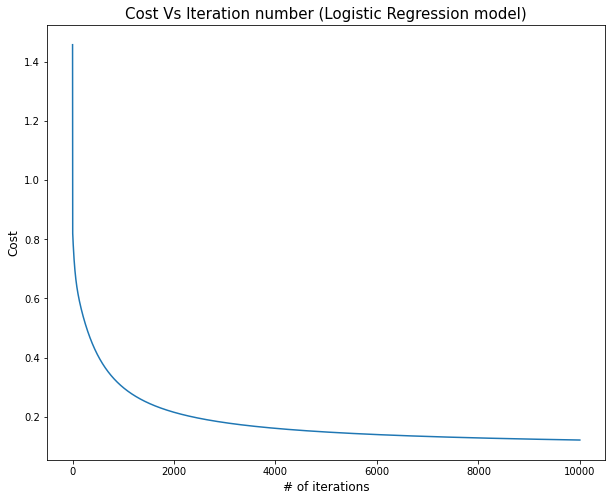

In [ ]:
#debugging
# best_eta=5e-05
# best_eps= 1e-06

print('For the first 1000 training points and first 500 test points:')
print('-------------------------------------------------------------')

# 1000 points from the training set (take the first original 1000 points - before the shuffle)
X_training_subset, labels_training_subset = X_training[:1000], y_training[:1000]

# 500 points from the test
X_test_subset, labels_test_subset = X_test[:500], y_test[:500]

# fit logistic regression with best params found earlier
log_reg_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) # define model with best params
log_reg_model.fit(X_training_subset, labels_training_subset) # fit to training set 

log_reg_training_preds = log_reg_model.predict(X_training_subset) # predict with training subset
log_reg_test_preds = log_reg_model.predict(X_test_subset) # predict with test subset

log_reg_training_accuracy = (labels_training_subset == log_reg_training_preds).sum() / len(labels_training_subset) # training accuracy
log_reg_test_accuracy = (labels_test_subset == log_reg_test_preds).sum() / len(labels_test_subset) # test set accuracy

print(f'Logistic Regression: Training Accuracy: {log_reg_training_accuracy * 100}%, Test Accuracy: {log_reg_test_accuracy * 100}%')

# fit Naive Bayes model (need to select the number of gaussians in the EM)
naive_bayes_model = NaiveBayesGaussian(k=2) # define model with 2 gaussians
naive_bayes_model.fit(X_training_subset, labels_training_subset) # fit to training set

naive_bayes_training_predictions = naive_bayes_model.predict(X_training_subset) # predict with training accuracy
naive_bayes_test_predictions = naive_bayes_model.predict(X_test_subset) # predict with test set accuracy

naive_bayes_training_accuracy = (labels_training_subset == naive_bayes_training_predictions).sum() / len(labels_training_subset) # training accuracy
naive_bayes_test_accuracy = (labels_test_subset == naive_bayes_test_predictions).sum() / len(labels_test_subset) # testset accuracy

print(f'Naive Bayes: Training Accuracy: {naive_bayes_training_accuracy * 100}%, Test Accuracy: {naive_bayes_test_accuracy * 100}%')

# use plot_decision_regions() to plot the decision boundaries for each model (use the training set as the input)
print()
plot_decision_regions(X_training_subset, labels_training_subset, log_reg_model)
plt.title('Decision Boundaries for Logistic Regression Model', fontsize=15)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.show()

plot_decision_regions(X_training_subset, labels_training_subset, naive_bayes_model)
plt.title('Decision Boundaries for Naive Bayes Model', fontsize=15)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.show()

# plot the cost Vs the iteration number for the Logistic Regression model
plt.plot(log_reg_model.J_history)
plt.title('Cost Vs Iteration number (Logistic Regression model)', fontsize=15)
plt.xlabel('# of iterations', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.show()

Plotting Explanations:

It can be seen in both graphs that there are two classes within the data that are relatively well separated. Due to this clear split and the linear separability, both the Logistic Regression and Naive Bayes model will produce accurate results (above 90% for both). 

However, the Naive Bayes model does have slightly higher accuracy. This is probably due to the bent line in the separation. The iteration vs cost plot for the Logistic Regression model has a logarthmic shape, which makes sense considering it is based on logarthmic functions so it leads to quicker convergence.

### Use all the training set points

For all the training set points:
-------------------------------------------------------------
Logistic Regression: Training Accuracy: 80.9%, Test Accuracy: 80.4%
Naive Bayes: Training Accuracy: 92.15%, Test Accuracy: 90.2%



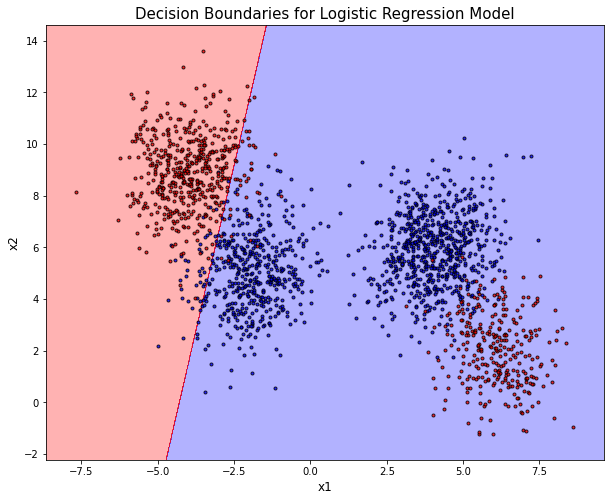

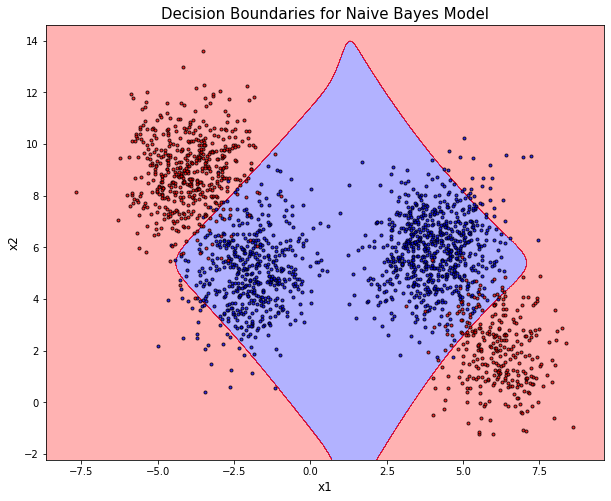

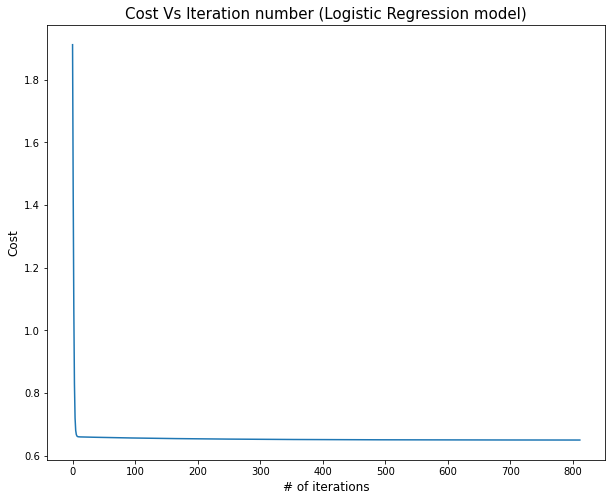

In [ ]:
print('For all the training set points:')
print('-------------------------------------------------------------')

# fit logistic regression with best params found earlier
log_reg_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) # define model with best params
log_reg_model.fit(X_training, y_training) # fit to training set 

log_reg_training_preds = log_reg_model.predict(X_training) # predict with training subset
log_reg_test_preds = log_reg_model.predict(X_test) # predict with test subset

log_reg_training_accuracy = (y_training == log_reg_training_preds).sum() / len(y_training) # training accuracy
log_reg_test_accuracy = (y_test == log_reg_test_preds).sum() / len(y_test) # test set accuracy

print(f'Logistic Regression: Training Accuracy: {log_reg_training_accuracy * 100}%, Test Accuracy: {log_reg_test_accuracy * 100}%')

# fit Naive Bayes model (need to select the number of gaussians in the EM)
naive_bayes_model = NaiveBayesGaussian(k=2) # define model with 2 gaussians
naive_bayes_model.fit(X_training, y_training) # fit to training set

naive_bayes_training_predictions = naive_bayes_model.predict(X_training) # predict with training accuracy
naive_bayes_test_predictions = naive_bayes_model.predict(X_test) # predict with test set accuracy

naive_bayes_training_accuracy = (y_training == naive_bayes_training_predictions).sum() / len(y_training) # training accuracy
naive_bayes_test_accuracy = (y_test == naive_bayes_test_predictions).sum() / len(y_test) # testset accuracy

print(f'Naive Bayes: Training Accuracy: {naive_bayes_training_accuracy * 100}%, Test Accuracy: {naive_bayes_test_accuracy * 100}%')

# use plot_decision_regions() to plot the decision boundaries for each model (use the training set as the input)
print()
plot_decision_regions(X_training, y_training, log_reg_model)
plt.title('Decision Boundaries for Logistic Regression Model', fontsize=15)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.show()

plot_decision_regions(X_training, y_training, naive_bayes_model)
plt.title('Decision Boundaries for Naive Bayes Model', fontsize=15)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.show()

# plot the cost Vs the iteration number for the Logistic Regression model
plt.plot(log_reg_model.J_history)
plt.title('Cost Vs Iteration number (Logistic Regression model)', fontsize=15)
plt.xlabel('# of iterations', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.show()

Plotting Explanation:

Given that we know the full dataset is not linearly separable, it is still possible that it could be separable by a plane in a higher dimension. Due to this, it can be expected that Logistic Regression will not perform as well as Naive Bayes. 

This is shown in plotting decision boundaries for the Logistic Regression model, where the boundary only separates 3 out of the 4 classes in the data. Despite this, the accuracy is still high (above 80%) which could be due to just chance. The iteration vs cost graph bere is less logarithmic, probably because the algorithm was so quick to find the first linear separator that it didn't give the classic log shape.

In the decision boundary graph of the Naive Bayes model, the decision boundary is defined much better. This shows that the EM algorithm with Naive Bayes handles the data better by separating with a plane and this can be seen in the accuracy (over 90%). 

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

In [ ]:
from scipy.stats import multivariate_normal

#### Your code and explanations here ####


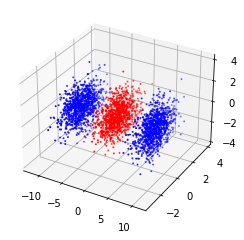

In [ ]:
# 3 dimensions (3 features) with 2 classes with only Multivariate-Gaussians that Naive Bayes will work better than Logistic Regression

cov = [[1, 0, 0], 
       [0, 1, 0],
       [0, 0, 1]]  

gaus1 = np.random.multivariate_normal(mean=[0, 0, 0], cov=cov, size=1000)
gaus2 = np.random.multivariate_normal(mean=[8, 0, 0], cov=cov, size=1000)
gaus3 = np.random.multivariate_normal(mean=[-8, 0, 0], cov=cov, size=1000)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(gaus1[:,0],gaus1[:,1],gaus1[:,2], s=1, color='red')
ax.scatter(gaus2[:,0],gaus2[:,1],gaus2[:,2], s=1, color='blue')
ax.scatter(gaus3[:,0],gaus3[:,1],gaus3[:,2], s=1, color='blue')
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# X = np.concatenate([gaus1,gaus2,gaus3])
# Y = 1000*[1]+1000*[0]+1000*[0]
# Y = np.array(Y)
# print(X.shape)

# X_training, X_test, y_training, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [ ]:
# #fit logistic regression with best params found earlier

# log_reg_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) # define model with best params
# log_reg_model.fit(X_training, y_training) # fit to training set 

# log_reg_training_preds = log_reg_model.predict(X_training) # predict with training subset
# log_reg_test_preds = log_reg_model.predict(X_test) # predict with test subset

# log_reg_training_accuracy = (y_training == log_reg_training_preds).sum() / len(y_training) # training accuracy
# log_reg_test_accuracy = (y_test == log_reg_test_preds).sum() / len(y_test) # test set accuracy

# print(f'Logistic Regression: Training Accuracy: {log_reg_training_accuracy * 100}%, Test Accuracy: {log_reg_test_accuracy * 100}%')

# # fit Naive Bayes model (need to select the number of gaussians in the EM)
# naive_bayes_model = NaiveBayesGaussian(k=2) # define model with 2 gaussians
# naive_bayes_model.fit(X_training, y_training) # fit to training set

# naive_bayes_training_predictions = naive_bayes_model.predict(X_training) # predict with training accuracy
# naive_bayes_test_predictions = naive_bayes_model.predict(X_test) # predict with test set accuracy

# naive_bayes_training_accuracy = (y_training == naive_bayes_training_predictions).sum() / len(y_training) # training accuracy
# naive_bayes_test_accuracy = (y_test == naive_bayes_test_predictions).sum() / len(y_test) # testset accuracy

# print(f'Naive Bayes: Training Accuracy: {naive_bayes_training_accuracy * 100}%, Test Accuracy: {naive_bayes_test_accuracy * 100}%')


Explain reasoning

Logistic Regression: Training Accuracy: 67.2%, Test Accuracy: 65.06666666666666%

Naive Bayes: Training Accuracy: 100.0%, Test Accuracy: 100.0%

The data is not linearly seperatable, therefore logistic regression will not work well.
Logistic Regression will create a decision boundary between the red points "cloud" and either one of the blue points "cloud". 
A dataset where Naive Bayes will work better than Logsitic Regression is one which is not linearly separable. In this case, Naive Bayes will identify the true classifications of the data points. 



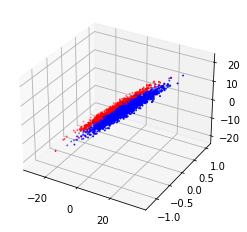

In [ ]:
cov = [[100, 0, 70], 
       [0, 0.1, 0],
       [0, 0, 0.1]]  

gaus1 = np.random.multivariate_normal(mean=[0, 0, 0], cov=cov, size=1000)
gaus2 = np.random.multivariate_normal(mean=[5, 0, 0], cov=cov, size=1000)
gaus3 = np.random.multivariate_normal(mean=[5, 0, 0], cov=cov, size=1000)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(gaus1[:,0],gaus1[:,1],gaus1[:,2], s=1, color='red')
ax.scatter(gaus2[:,0],gaus2[:,1],gaus2[:,2], s=1, color='blue')
ax.scatter(gaus3[:,0],gaus3[:,1],gaus3[:,2], s=1, color='blue')


plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# X = np.concatenate([gaus1,gaus2,gaus3])
# Y = 1000*[1]+1000*[0]+1000*[0]
# Y = np.array(Y)
# print(X.shape)

# X_training, X_test, y_training, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [ ]:
# #fit logistic regression with best params found earlier

# log_reg_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) # define model with best params
# log_reg_model.fit(X_training, y_training) # fit to training set 

# log_reg_training_preds = log_reg_model.predict(X_training) # predict with training subset
# log_reg_test_preds = log_reg_model.predict(X_test) # predict with test subset

# log_reg_training_accuracy = (y_training == log_reg_training_preds).sum() / len(y_training) # training accuracy
# log_reg_test_accuracy = (y_test == log_reg_test_preds).sum() / len(y_test) # test set accuracy

# print(f'Logistic Regression: Training Accuracy: {log_reg_training_accuracy * 100}%, Test Accuracy: {log_reg_test_accuracy * 100}%')

# # fit Naive Bayes model (need to select the number of gaussians in the EM)
# naive_bayes_model = NaiveBayesGaussian(k=2) # define model with 2 gaussians
# naive_bayes_model.fit(X_training, y_training) # fit to training set

# naive_bayes_training_predictions = naive_bayes_model.predict(X_training) # predict with training accuracy
# naive_bayes_test_predictions = naive_bayes_model.predict(X_test) # predict with test set accuracy

# naive_bayes_training_accuracy = (y_training == naive_bayes_training_predictions).sum() / len(y_training) # training accuracy
# naive_bayes_test_accuracy = (y_test == naive_bayes_test_predictions).sum() / len(y_test) # testset accuracy

# print(f'Naive Bayes: Training Accuracy: {naive_bayes_training_accuracy * 100}%, Test Accuracy: {naive_bayes_test_accuracy * 100}%')


Explain reasoning

Logistic Regression: Training Accuracy: 100.0%, Test Accuracy: 100.0%

Naive Bayes: Training Accuracy: 32.800000000000004%, Test Accuracy: 34.93333333333333%

A dataset where Logistic Regression will work better than Naive Bayes is one that is linearly separable. Logistic Regression will have high accuracy as it will be able to accurately place the linear separator between the blue and red points. Naive Bayes will not perform as well because it will assume independence between the features x1, x2, x3.  But we know that features x1 and x3 are highly dependent according to the covariance matrix.

In [ ]:
#I asked Ben in the email, related to the numpy version
import numpy
print(numpy.version.version)

import sys
print(sys.version)

1.21.5
3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
